In [1]:
dataset_name = "ambient_temperature_system_failure"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import matplotlib.pyplot as plt
import holidays
import joblib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:939: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/cfreeman/Documents/NextIT/adclasses2/adclasses2_venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


#  Preprocess Dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)
data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, '1H', data))

data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")
ad = adclasses.UnivariateAnomalyDetection(dataframe=data, timestep="1H", dateformat="%Y-%m-%d %H:%M:%S", name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2013-12-22 20:00:00",
                      "2014-04-13 09:00:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2013-07-04 00:00:00
End date:  2014-05-28 15:00:00
Missing time stamps: 
 DatetimeIndex(['2013-07-28 02:00:00', '2013-07-28 05:00:00',
               '2013-07-28 06:00:00', '2013-07-28 07:00:00',
               '2013-07-28 08:00:00', '2013-07-28 09:00:00',
               '2013-07-28 10:00:00', '2013-07-28 11:00:00',
               '2013-07-28 12:00:00', '2013-07-28 13:00:00',
               ...
               '2014-04-10 05:00:00', '2014-04-10 06:00:00',
               '2014-04-10 07:00:00', '2014-04-10 08:00:00',
               '2014-04-10 09:00:00', '2014-04-10 10:00:00',
               '2014-04-10 11:00:00', '2014-04-10 12:00:00',
               '2014-04-10 13:00:00', '2014-04-10 14:00:00'],
              dtype='datetime64[ns]', length=621, freq=None)
Length:  7888
Time step size:  1H
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [4124, 6801]


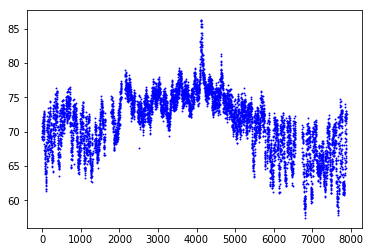

In [4]:
ad.plot_outliers([],[])

# Donut

Trainable Parameters              (58,150 in total)
---------------------------------------------------
donut/p_x_given_z/x_mean/bias    (120,)         120
donut/p_x_given_z/x_mean/kernel  (100, 120)  12,000
donut/p_x_given_z/x_std/bias     (120,)         120
donut/p_x_given_z/x_std/kernel   (100, 120)  12,000
donut/q_z_given_x/z_mean/bias    (5,)             5
donut/q_z_given_x/z_mean/kernel  (100, 5)       500
donut/q_z_given_x/z_std/bias     (5,)             5
donut/q_z_given_x/z_std/kernel   (100, 5)       500
sequential/_0/dense/bias         (100,)         100
sequential/_0/dense/kernel       (5, 100)       500
sequential/_1/dense/bias         (100,)         100
sequential/_1/dense/kernel       (100, 100)  10,000
sequential_1/_0/dense/bias       (100,)         100
sequential_1/_0/dense/kernel     (120, 100)  12,000
sequential_1/_1/dense/bias       (100,)         100
sequential_1/_1/dense/kernel     (100, 100)  10,000

[Epoch 10/256, Step 20, ETA 22.15s] Learning rate decreased to 

INFO:tensorflow:Restoring parameters from /tmp/tmpmuecwej6/variables.dat-500


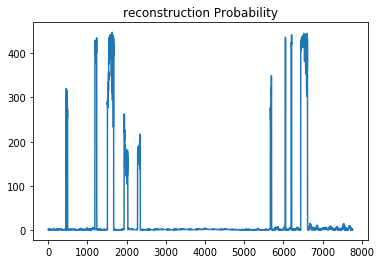

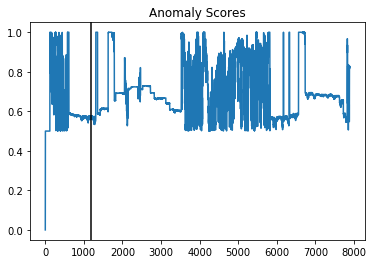

Time:  67.54248714447021


['anomaly_scores/Donut/ambient_temperature_system_failure_no_fill']

In [4]:
save_path = "anomaly_scores/Donut/" + dataset_name + "_no_fill"
output_dict = ad.donut(gaussian_window_size=gaussian_window_size,plot_reconstruction_prob=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

#  STL Resid

R stlplus completed:   missing. will fill. True


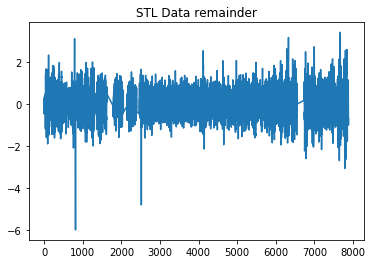

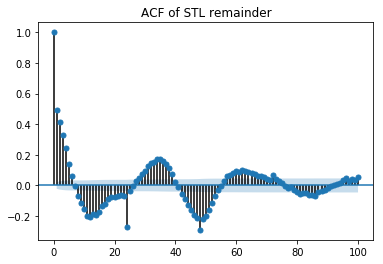

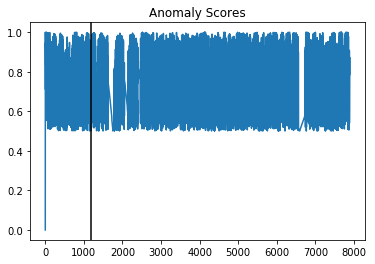

Time:  2.490755558013916


['anomaly_scores/stl/ambient_temperature_system_failure_no_fill']

In [5]:
save_path = "anomaly_scores/stl/" + dataset_name + "_no_fill"
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size,n_periods=24, swindow=7, outer=1, fill_option="linear", plot_resid=True, plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)